<a href="https://colab.research.google.com/github/ChaaruVijay/DSPL-CourseWork/blob/main/XGB_Boost_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Building Predictive Models - XGB Model**

In [2]:
!pip install xgboost
!pip install scikit-learn

In [3]:
#Loading the dataset
import pandas as pd
import numpy as ny
data = pd.read_csv('/content/train_cleaned.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774055 entries, 0 to 774054
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   outlet_city       774055 non-null  int64  
 1   luxury_sales      774055 non-null  float64
 2   fresh_sales       774055 non-null  float64
 3   dry_sales         774055 non-null  float64
 4   cluster_catgeory  774055 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 29.5 MB


In [6]:
#Splitting train.csv into training and testing
from sklearn.model_selection import train_test_split


X = data.drop('cluster_catgeory', axis=1)
y = data['cluster_catgeory']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [7]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [8]:
print("Unique values in y_train:", y_train.unique())

Unique values in y_train: [1 2 5 3 4 6]


In [9]:
#Since the model expecs all to be start from 0
y_train = y_train - 1
y_test = y_test - 1
print("Unique values in y_train:", y_train.unique())

Unique values in y_train: [0 1 4 2 3 5]


**Model Development**

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [23]:
# Define the base model with lower complexity
xgb_model = XGBClassifier(
    n_estimators=50,  # Speed
    max_depth=4,  # Adjusted to a reasonable level for accuracy and speed
    learning_rate=0.1,
    subsample=0.8,
    tree_method="hist",  # Speeds up training
    verbosity=1  # Shows progress
)

In [24]:
# Reduce the search space to fewer but effective combinations
param_grid = {
    'max_depth': [3, 4, 5],  # Smallest effective values
    'learning_rate': [0.05, 0.1],  # Avoid too many steps
    'n_estimators': [50, 100],  # Lower for faster training
    'subsample': [0.7, 0.8, 1.0],  # More variation for generalization
    'reg_lambda': [1, 5],  # L2 regularization for stability
    'reg_alpha': [0, 0.1],  # L1 regularization for feature control
}

In [25]:
# Use RandomizedSearchCV for faster tuning with fewer iterations
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=10,  # Fewer iterations to speed up the process
    cv=3,  # Keep 3 folds for cross-validation
    scoring='accuracy',
    verbose=1,
    n_jobs=-1  # Use all available CPU cores for faster processing
)

In [26]:
# Train the model
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None, n_estimators=50,
                                           n_jobs=None, num_parallel_tree=None,
                                           random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [50, 100],
                                        'reg_alpha': [0, 0.1],
                                        'reg_lambda': [1, 5],
                                        'subsample': [0.7, 0.8, 1.0]},
                   scoring='accuracy', verbose=1)

In [27]:
# Best parameters from RandomizedSearchCV
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'subsample': 1.0, 'reg_lambda': 5, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}


In [28]:
# Evaluate the best model from the search
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Best Model Accuracy: {accuracy_best * 100:.2f}%")

Best Model Accuracy: 99.98%


**Confusion Matrix**

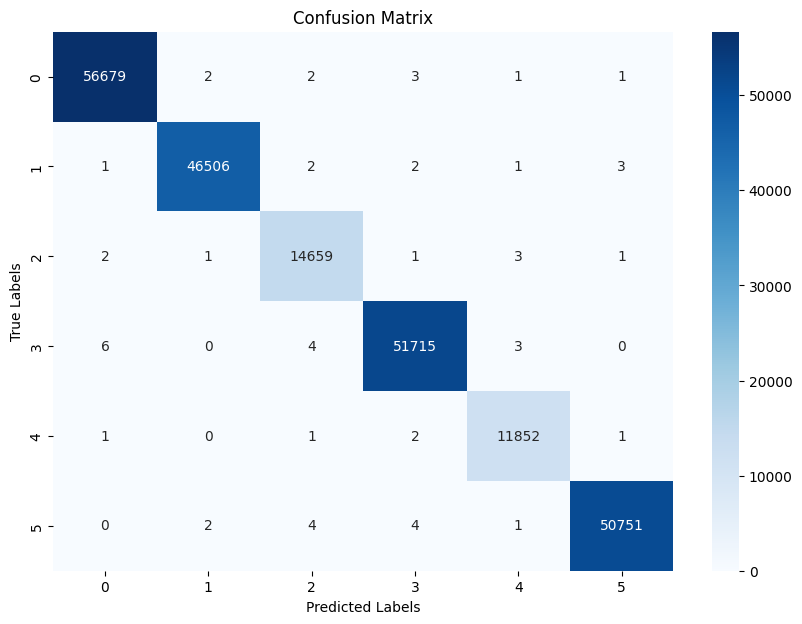

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(0, len(cm)), yticklabels=range(0, len(cm)))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


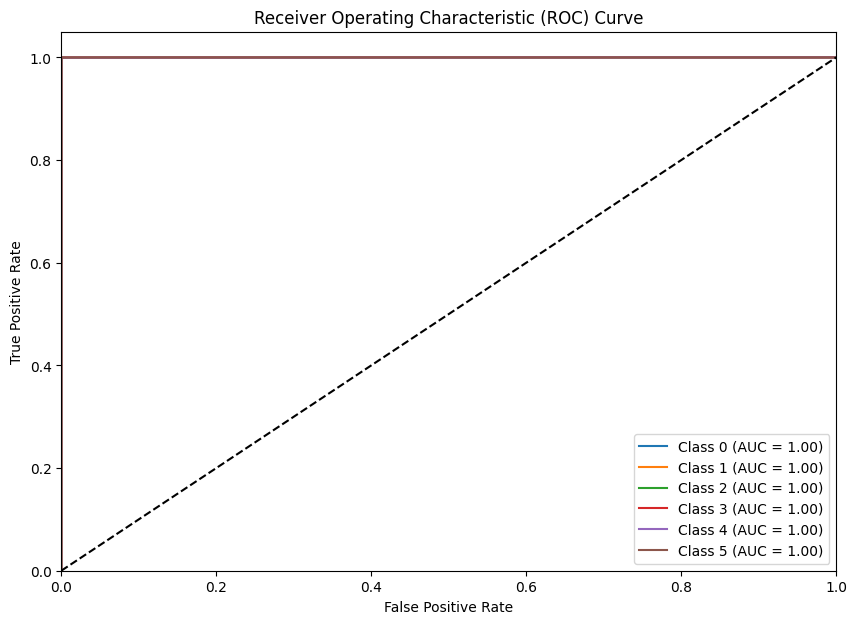

Overall AUC Score: 0.9999


In [30]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the output labels for multi-class classification
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])  # Modify as per your classes
y_pred_prob = best_model.predict_proba(X_test)  # Get the predicted probabilities for each class

# Calculate ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(cm)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure(figsize=(10, 7))
for i in range(len(cm)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



**AUC Score**

In [33]:
# Calculate AUC Score
overall_auc = roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr')
print(f'Overall AUC Score: {overall_auc:.4f}')


Overall AUC Score: 0.9999


In [31]:
# Evaluate on the training set
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Training Accuracy: 99.98%
Test Accuracy: 99.98%


**Cross-Validation:**

In [32]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.99979699 0.99967703 0.99971394 0.9998339  0.99978776]
Mean cross-validation score: 0.9997619216404401
